In [13]:
from transformers import pipeline
import torch
from torch.utils.data import DataLoader
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, udf, col, current_date, date_sub
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers import SentenceTransformer, util

In [14]:
spark = SparkSession.builder \
        .appName("Similarity_scores") \
        .getOrCreate()

In [15]:
news_sources = [
    ("cnn", "../ml_data/cnn.csv"),
    ("foxnews", "../ml_data/foxnews.csv"),
    ("cbc", "../ml_data/cbc.csv"),
    ("nytimes", "../ml_data/nytimes.csv"),
    ("theguardian", "../ml_data/theguardian.csv"),
    ("washingtonpost", "../ml_data/washingtonpost.csv"),
    ("wsj", "../ml_data/wsj.csv")
]

spark_dfs = {} 
for name, path in news_sources:
    pd_df = pd.read_csv(path)
    spark_df = spark.createDataFrame(pd_df)
    spark_dfs[name] = spark_df

### Text Preprocessing:
* Remove \n\n
* Remove articles where text is null

In [16]:
processed_dfs = {}

for name,df in spark_dfs.items():
    processed_df = df.select("date", "title", "text", "short_description").na.drop(subset=["text"]).withColumn("text", regexp_replace(df["text"], "\n\n", " "))
    processed_dfs[name] = processed_df

In [17]:
# Define custom function for similarity computation
def compute_similarity(title, text):
    sentences = sent_tokenize(text)
    title_embedding = model.encode(title)

    max_similarity = float("-inf")
    associated_sentence = ""
    similarities = []

    for sentence in sentences:
        # Generate embedding for each sentence
        sentence_embedding = model.encode(sentence)

        # Compute similarity
        similarity = util.cos_sim(title_embedding, sentence_embedding)
        similarity_value = similarity.item()  # Extract the scalar value

        if similarity_value > max_similarity:
            max_similarity = similarity_value
            associated_sentence = sentence

        similarities.append(similarity_value)

    average_similarity = np.mean(similarities) if similarities else 0
    sorted_similarities = sorted(similarities, reverse=True)

    return sorted_similarities, average_similarity, max_similarity, len(sentences)

In [18]:
# model being used: https://huggingface.co/Sakil/sentence_similarity_semantic_search
model_name = "Sakil/sentence_similarity_semantic_search"
model = SentenceTransformer(model_name)

In [19]:
results_df = pd.DataFrame(columns=["News Source", "Average Similarity Top 5", "Average Article Length", "Overall Average Similarity"])

### CNN:

In [20]:
cnn_processed_df = processed_dfs["cnn"]
cnn_processed_df = cnn_processed_df.withColumn("short_description", regexp_replace(cnn_processed_df["short_description"], r"\s+CNN$", "")).withColumn("text", regexp_replace(cnn_processed_df["text"], r'\s*(\w+)\s+\w+/\w+$', ''))
# cnn_processed_df.select("text").show(5, truncate=False)

In [21]:
# Compute similarity for CNN articles past week:
weekago  = date_sub(current_date(), 7)
articles = cnn_processed_df.filter(col("date") >= weekago).collect()
n_articles = len(articles)
top5_similarity_sum_cnn = 0
avg_sentence_length = 0
overall_avg_similarity_cnn = 0

for row in articles:
    title = row["title"]
    text = row["text"]
    sorted_similarities, average_similarity, max_similarity, n_sentences = compute_similarity(title, text)
    top5_similarity_sum_cnn += np.mean(sorted_similarities[:5])
    avg_sentence_length += n_sentences
    overall_avg_similarity_cnn += average_similarity

new_row = {
    "News Source": "CNN",
    "Average Similarity Top 5": top5_similarity_sum_cnn/n_articles,
    "Average Article Length": avg_sentence_length/n_articles,
    "Overall Average Similarity": overall_avg_similarity_cnn/n_articles,
    "Articles This Week": n_articles
}
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

### Fox News:


In [22]:
fox_processed_df = processed_dfs["foxnews"]
fox_processed_df = fox_processed_df.withColumn("text", regexp_replace("text", "Join Fox News for access to this content Plus special access to select articles and other premium content with your account - free of charge. Please enter a valid email address.", ""))\
    .withColumn("text", regexp_replace("text", "CLICK HERE TO GET THE FOX NEWS APP", "")).withColumn("title", regexp_replace("title", "CLICK HERE TO GET THE FOX NEWS APP", ""))
# fox_processed_df.select('text').show(5, truncate=False)

In [23]:
# Compute similarity for Fox articles past week:
weekago  = date_sub(current_date(), 7)
articles = fox_processed_df.filter(col("date") >= weekago).collect()
n_articles = len(articles)
top5_similarity_sum_fox = 0
avg_sentence_length = 0
overall_avg_similarity_fox = 0

for row in articles:
    title = row["title"]
    text = row["text"]
    sorted_similarities, average_similarity, max_similarity, n_sentences = compute_similarity(title, text)
    top5_similarity_sum_fox += np.mean(sorted_similarities[:5])
    avg_sentence_length += n_sentences
    overall_avg_similarity_fox += average_similarity

new_row = {
    "News Source": "Fox",
    "Average Similarity Top 5": top5_similarity_sum_fox/n_articles,
    "Average Article Length": avg_sentence_length/n_articles,
    "Overall Average Similarity": overall_avg_similarity_fox/n_articles,
    "Articles This Week": n_articles
}
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

### The Guardian:

In [24]:
guardian_processed_df = processed_dfs["theguardian"]
# guardian_processed_df.select('text').show(10, truncate=False)

In [25]:
# Compute similarity for The Guardian articles past week:
weekago  = date_sub(current_date(), 7)
articles = guardian_processed_df.filter(col("date") >= weekago).collect()
n_articles = len(articles)
top5_similarity_sum_guardian = 0
avg_sentence_length = 0
overall_avg_similarity_guardian = 0

for row in articles:
    title = row["title"]
    text = row["text"]
    sorted_similarities, average_similarity, max_similarity, n_sentences = compute_similarity(title, text)
    top5_similarity_sum_guardian += np.mean(sorted_similarities[:5])
    avg_sentence_length += n_sentences
    overall_avg_similarity_guardian += average_similarity

new_row = {
    "News Source": "The Guardian",
    "Average Similarity Top 5": top5_similarity_sum_guardian/n_articles,
    "Average Article Length": avg_sentence_length/n_articles,
    "Overall Average Similarity": overall_avg_similarity_guardian/n_articles,
    "Articles This Week": n_articles
}
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

In [26]:
wpost_processed_df = processed_dfs["washingtonpost"]
wpost_processed_df = wpost_processed_df.withColumn("text", regexp_replace(wpost_processed_df["text"], r'\bAdvertisement\b', ''))
# wpost_processed_df.select("text").show(10, truncate=False)

In [27]:
# Compute similarity for Washington Post articles past week:
weekago  = date_sub(current_date(), 7)
articles = wpost_processed_df.filter(col("date") >= weekago).collect()
n_articles = len(articles)
top5_similarity_sum_wpost = 0
avg_sentence_length = 0
overall_avg_similarity_wpost = 0

for row in articles:
    title = row["title"]
    text = row["text"]
    sorted_similarities, average_similarity, max_similarity, n_sentences = compute_similarity(title, text)
    top5_similarity_sum_wpost += np.mean(sorted_similarities[:5])
    avg_sentence_length += n_sentences
    overall_avg_similarity_wpost += average_similarity

new_row = {
    "News Source": "Washington Post",
    "Average Similarity Top 5": top5_similarity_sum_wpost/n_articles,
    "Average Article Length": avg_sentence_length/n_articles,
    "Overall Average Similarity": overall_avg_similarity_wpost/n_articles,
    "Articles This Week": n_articles
}
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

In [28]:
cbc_processed_df = processed_dfs["cbc"]
cbc_processed_df = cbc_processed_df.withColumn("text", regexp_replace(cbc_processed_df["text"], r'\bAdvertisement\b', ''))
# cbc_processed_df.select("text").show(10, truncate=False)

In [29]:
# Compute similarity for CBC articles past week:
weekago  = date_sub(current_date(), 7)
articles = cbc_processed_df.filter(col("date") >= weekago).collect()
n_articles = len(articles)
top5_similarity_sum_cbc = 0
avg_sentence_length = 0
overall_avg_similarity_cbc = 0

for row in articles:
    title = row["title"]
    text = row["text"]
    sorted_similarities, average_similarity, max_similarity, n_sentences = compute_similarity(title, text)
    top5_similarity_sum_cbc += np.mean(sorted_similarities[:5])
    avg_sentence_length += n_sentences
    overall_avg_similarity_cbc += average_similarity

new_row = {
    "News Source": "CBC",
    "Average Similarity Top 5": top5_similarity_sum_cbc/n_articles,
    "Average Article Length": avg_sentence_length/n_articles,
    "Overall Average Similarity": overall_avg_similarity_cbc/n_articles,
    "Articles This Week": n_articles
}
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

24/03/08 00:27:41 WARN TaskSetManager: Stage 4 contains a task of very large size (1345 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
print(results_df)

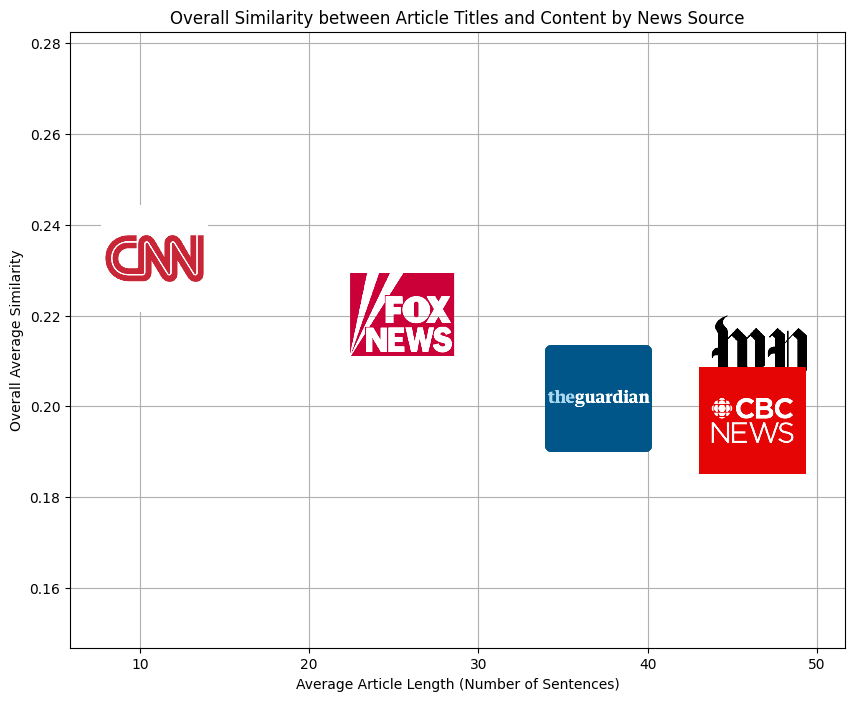

In [30]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.offsetbox import  OffsetImage, AnnotationBbox

icon_paths = {
    'CNN': '../Images/cnn.png',
    'Fox': '../Images/fox.png',
    'The Guardian': '../Images/guardian.png',
    'Washington Post': '../Images/wpost.png',
    'CBC': '../Images/cbc.png'
}

def load_image_with_alpha(path):
    with Image.open(path) as img:
        if img.mode != 'RGBA':
            img = img.convert('RGBA')
        return np.array(img)

fig, ax = plt.subplots(figsize=(10, 8))
for index, row in results_df.iterrows():
    news_source = row['News Source']
    x0 = row['Average Article Length']
    y0 = row['Overall Average Similarity']
    img_path = icon_paths[news_source]
    img_data = load_image_with_alpha(img_path)
    imagebox = OffsetImage(img_data, zoom=0.3)
    ab = AnnotationBbox(imagebox, (x0, y0), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel('Average Article Length (Number of Sentences)')
ax.set_ylabel('Overall Average Similarity')
ax.set_title('Overall Similarity between Article Titles and Content by News Source')

ax.set_xlim(min(results_df['Average Article Length']) - 5, max(results_df['Average Article Length']) + 5)
ax.set_ylim(min(results_df['Overall Average Similarity']) - 0.05, max(results_df['Overall Average Similarity']) + 0.05)

plt.grid(True)
plt.show()

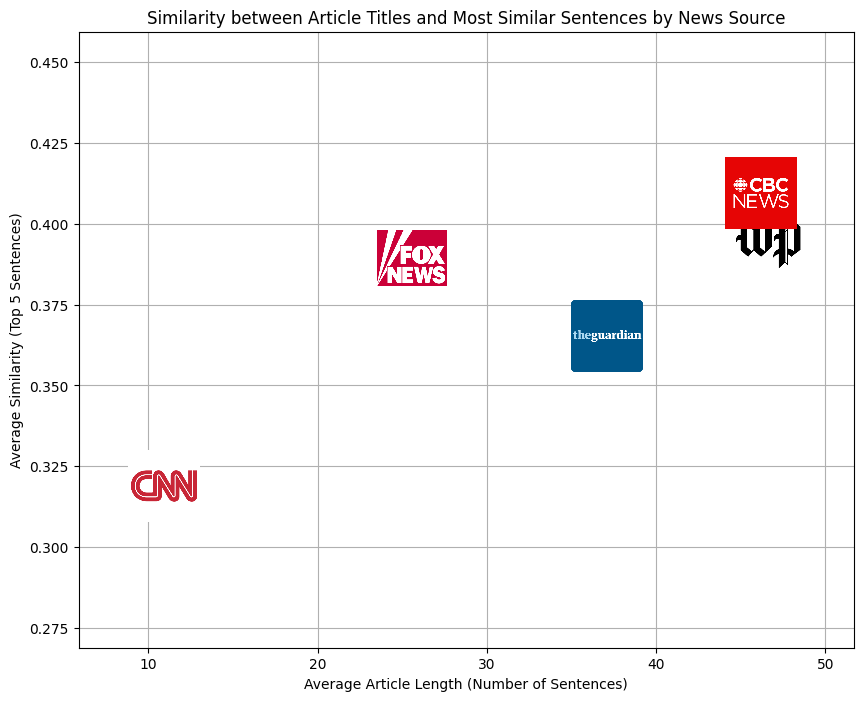

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
for index, row in results_df.iterrows():
    news_source = row['News Source']
    x0 = row['Average Article Length']
    y0 = row['Average Similarity Top 5']
    img_path = icon_paths[news_source]
    img_data = load_image_with_alpha(img_path)
    imagebox = OffsetImage(img_data, zoom=0.2)  # Adjust the zoom factor as necessary
    ab = AnnotationBbox(imagebox, (x0, y0), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel('Average Article Length (Number of Sentences)')
ax.set_ylabel('Average Similarity (Top 5 Sentences)')
ax.set_title('Similarity between Article Titles and Most Similar Sentences by News Source')

ax.set_xlim(min(results_df['Average Article Length']) - 5, max(results_df['Average Article Length']) + 5)
ax.set_ylim(min(results_df['Average Similarity Top 5']) - 0.05, max(results_df['Average Similarity Top 5']) + 0.05)

plt.grid(True)
plt.show()

In [32]:
spark.stop()

In [33]:
# tokenizer = Tokenizer(inputCol="text", outputCol="words")
# fox_selected_df = tokenizer.transform(fox_selected_df)

# remover = StopWordsRemover(inputCol="words", outputCol="clean_words")
# fox_selected_df = remover.transform(fox_selected_df)

# fox_selected_df = fox_selected_df.withColumn("clean_text", col("clean_words").cast("string"))

# fox_selected_df = fox_selected_df.drop("words", "clean_words", "clean_text")

# def tokenize_title(title):
#     return word_tokenize(title)
# tokenize_title_udf = udf(tokenize_title, ArrayType(StringType()))
# fox_selected_df = fox_selected_df.withColumn("title_tokens", tokenize_title_udf("title"))

# fox_selected_df.show(2, truncate=False)

In [34]:
# def nltk_sentence_tokenize(text):
#     sentences = nltk.sent_tokenize(text)
#     return sentences

# sentence_tokenize_udf = udf(nltk_sentence_tokenize, ArrayType(StringType()))
# fox_selected_df = fox_selected_df.withColumn("sentences", sentence_tokenize_udf(fox_selected_df["text"]))
# fox_selected_df.select("sentences").collect()[0]

In [35]:
# this code doesn't work for some reason, think there's some issues converting the similarity scores to a format that can append to pyspark df

# def compute_similarity(title, text):
#     title_tokens = word_tokenize(title)
#     sentences = nltk.sent_tokenize(text)

#     similarity_sum = 0
#     for sentence in sentences:
#         sentence_tokens = word_tokenize(sentence)
#         title_embedding = model.encode(title_tokens)
#         sentence_embedding = model.encode(sentence_tokens)

#         similarity = util.cos_sim(title_embedding, sentence_embedding)
#         similarity_sum += similarity[0][0]

#     average_similarity = similarity_sum / len(sentences)
#     return average_similarity

# compute_similarity_udf = udf(compute_similarity, \
#                              returnType=FloatType())

# result_df = fox_selected_df.withColumn("average_similarity", compute_similarity_udf("title", "text"))
# result_df.show(truncate=False)